### Preamble
This notebook is overviews pathwise conditioning in terms of Matheron's update rule

\begin{equation}
(f \mid \mathbf{y})(\cdot)
= 
    f(\cdot) + k(\cdot, \mathbf{X}_{n})\mathbf{K}_{n,n}^{-1}(\mathbf{y} - f(\mathbf{X}_{n})),
\end{equation}

which we may interpret as the sum of a prior random function $f(\cdot)$ and a data-driven update $k(\cdot, \mathbf{X}_{n})\mathbf{K}_{n,n}^{-1}(\mathbf{y} - f(\mathbf{X}_{n}))$.

**Overview**
- Here, we review use of `sampling.priors`, `sampling.updates`, and `sampling.decoupled`
- Other notebooks explore higher-level package API (such as model classes).

In [1]:
import numpy as np
import tensorflow as tf

from gpflow import kernels
from gpflow.config import default_float as floatx
from gpflow_sampling.sampling import priors, updates, decoupled

import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', dpi=256)
plt.rc('font', family='serif', size=10)
plt.rc('text', usetex=False)


C:\Users\nitsu\AppData\Roaming\Python\Python38\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.decorator.check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(
C:\Users\nitsu\AppData\Roaming\Python\Python38\site-packages\gpflow\experimental\utils.py:42: UserWarning: You're calling gpflow.experimental.check_shapes.inheritance.inherit_check_shapes which is considered *experimental*. Expect: breaking changes, poor documentation, and bugs.
  warn(


### Draw a function from a GP prior $f \sim \textrm{GP}(0, k)$
Here, we use Random Fourier Features [(Rahimi and Recht, 2007)](https://people.eecs.berkeley.edu/~brecht/papers/07.rah.rec.nips.pdf) to approximate $f$ as a Bayesian linear model

\begin{equation}
    f(\cdot) \stackrel{d}{\approx} \sum_{i=1}^{\ell} w_{i} \phi_{i}(\cdot),
\end{equation}

where $\phi_{i}(\mathbf{x}) \propto \cos(\boldsymbol{\theta}_{i}^\top \mathbf{x} + \tau_{i})$ denotes the $i$-th basis function and $w_{i} \sim \textrm{N}(0, 1)$ the corresponding random weight.

- Currently, `priors.random_fourier` supports Matern family base kernels, such as the Squared Exponential.
- Multioutput kernels based on independent latent kernels are also supported.
- For demonstration purposes, we will employ a multioutput kernel; the same API holds for scalar-valued kernels.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


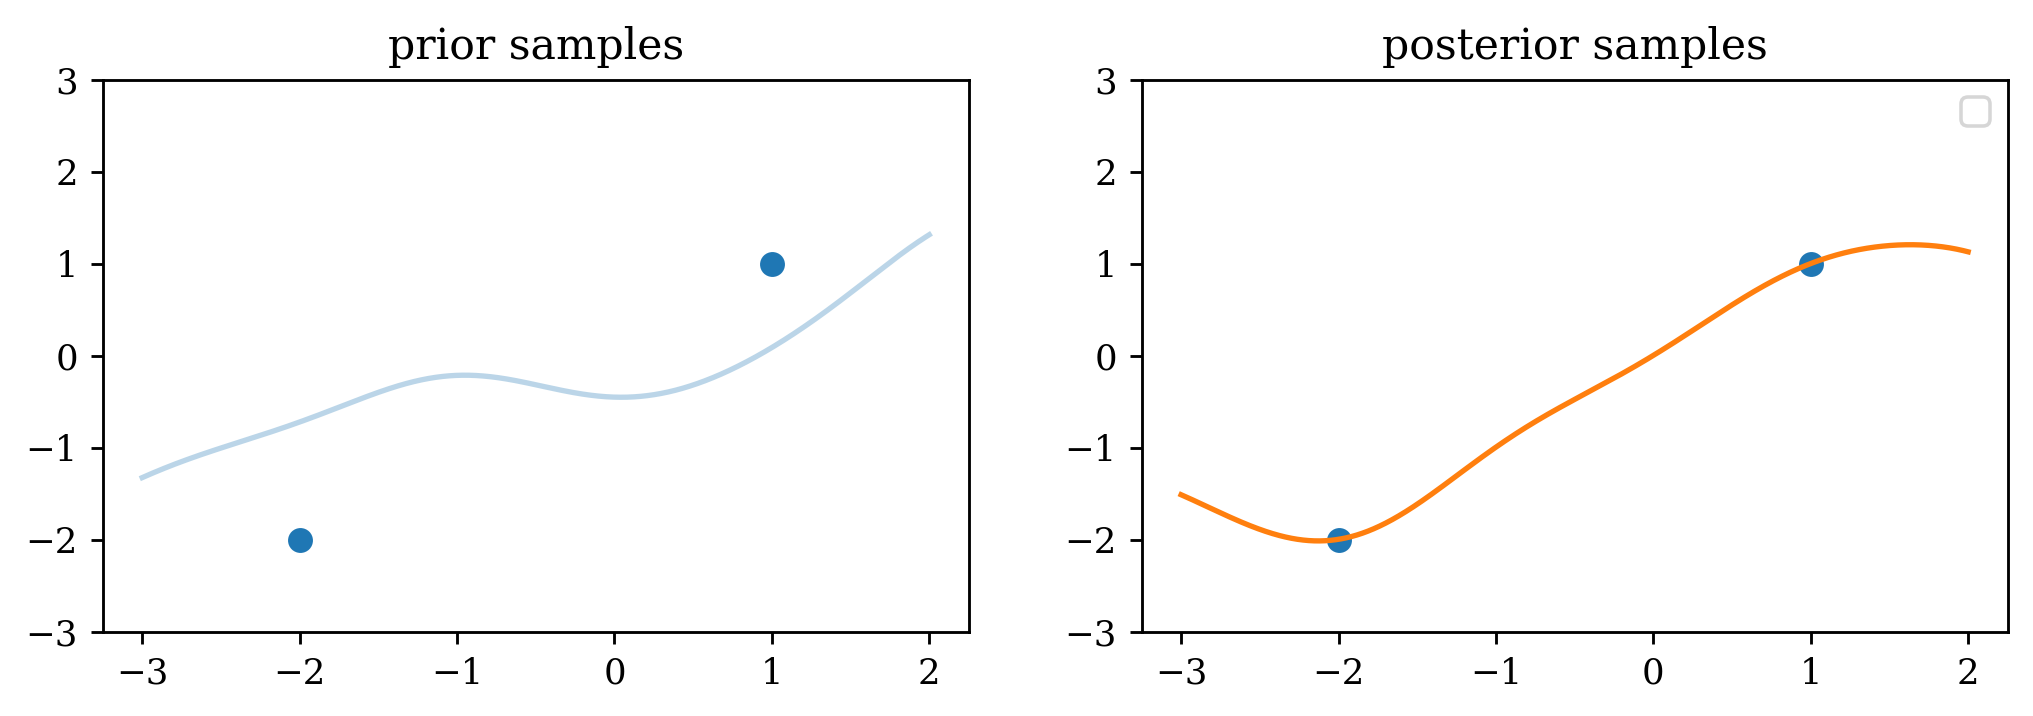

In [8]:
periodic_kernel = kernels.Periodic(base_kernel=kernels.SquaredExponential())
periodic_kernel.period.assign(5)
se_kernel = kernels.SquaredExponential()
kernel = periodic_kernel
prior_fn = priors.random_fourier(kernel, sample_shape=[1], num_bases=1024)
pX = tf.convert_to_tensor(np.linspace(-3, 2, 6024)[:, None])

X2 = tf.convert_to_tensor(np.array([-2, 1])[:, None], dtype=np.float64)
y2 = tf.convert_to_tensor(np.array([-2, 1])[:, None][None, :], dtype=np.float64)

posterior2_fn = decoupled(kernel, prior_fn, X2, y2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 2.8))
ax1.plot(pX, tf.squeeze(prior_fn(pX)), color='C0', alpha=0.3)
ax1.scatter(tf.squeeze(X2), tf.squeeze(y2))
ax1.set_ylim(-3, 3)
ax1.set_title("prior samples")

ax2.scatter(tf.squeeze(X2), tf.squeeze(y2))
ax2.plot(pX, tf.squeeze(posterior2_fn(pX)), color='C1')
ax2.set_ylim(-3, 3)
ax2.set_title("posterior samples")
ax2.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(7, 3))
for i, kern in enumerate(kernel.kernels):
    ax.plot(Xnew, Fnew[0, ..., i], linewidth=1, alpha=3/4,
            label=''.join(term.capitalize() for term in kern.name.split('_'))) 

_ = ax.set_xlim(0, 1)
_ = ax.legend(loc='upper center', 
              bbox_to_anchor=(0.5, 1.15), 
              ncol=len(kernel.kernels),
              frameon=False,
              fontsize=10,
              handlelength=1.25)

### Specify conditions $f(\mathbf{X}) = \mathbf{0}$

In [ ]:
X = tf.convert_to_tensor(np.linspace(0.15, 0.5, 4)[:, None])
y = tf.zeros([1, len(X), 1], dtype=floatx())

### Construct pathwise updates

In [ ]:
update_fn = updates.exact(kernel, X, y, prior_fn(X), diag=0.0)
dFnew = update_fn(Xnew)  # [1, 1024, 3]

### Decoupled sampling
- `sampling.decoupled` solves for a pathwise update and combines it with function draws from the prior.
- The `update_rule` keyword argument specifies how the update is constructed (defaults to `sampling.updates.exact`).
- For `gpflow.kernels.LinearCoregionalization`, the returned object internally mixes the latent GPs.

In [ ]:
decoupled_fn = decoupled(kernel, prior_fn, X, y, diag=0.0)
assert tf.reduce_all(decoupled_fn(Xnew) == Fnew + dFnew)

# # Approximately solve for the update using preconditioned CG
# decoupled_fn = sampling.decoupled(kernel, prior_fn, X, y, update_rule=updates.cg)

### Visualize  decoupled samples

In [ ]:
fig, axes = plt.subplots(figsize=(7, 2), ncols=3, sharey='row')
for i, ax in enumerate(axes):
    for x in X:  # indicate training locations
        ax.axvline(x, 
                   linewidth=3,
                   zorder=0,
                   alpha=0.25,
                   color='silver')

    ax.axhline(0, linestyle='--', linewidth=1/2, color='k', zorder=0)
    ax.set_xlim(0, 1)

# Plot components of decoupled sample paths
for i, kern in enumerate(kernel.kernels):
    f_i = Fnew[0, ..., i]
    df_i = dFnew[0, ..., i]
    axes[0].plot(Xnew, f_i, linewidth=1, alpha=3/4)
    axes[1].plot(Xnew, df_i, linewidth=1, alpha=3/4)
    axes[2].plot(Xnew, f_i + df_i, linewidth=1, alpha=3/4)
    
for ax in axes:
    ylim = max(abs(val) for val in ax.get_ylim())
    ax.set_ylim(-ylim, ylim)

axes[0].set_title('Prior functions')

axes[1].set_title('Pathwise updates')

axes[2].set_title('Conditioned paths')
plt.tight_layout()